# Arch mice notebook - extract ALL information you want

In [1]:
# Imports:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import math
import psycopg2
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm_notebook

from scipy import signal 

# Plotting:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set()

# External functions from subfolder /database_helpers. 
# as soon as you change something in there and press save, it will auto reload on next execution.
from database_helpers.psql_start import *
from database_helpers.create_tables import *
from database_helpers.write2tables import *
from postgres_analysis_helpers.general import *
from postgres_analysis_helpers.get_data import *
from postgres_analysis_helpers.circstat_functions import *
from postgres_analysis_helpers.extra_analysis import *

# register pickle type to retrieve binary data from database
psycopg2.extensions.register_type(psycopg2.extensions.new_type(psycopg2.BINARY.values, 'BINARY-PICKLE', cast_pickle))

Loaded analysis helpers: General
Loaded postgres_analysis_helpers -> general
Loaded postgres_analysis_helpers -> get_data
Loaded postgres_analysis_helpers -> circstat_functions
Loaded postgres_analysis_helpers -> extra analysis


In [2]:
# Database connection check
db_status = test_connect()
if db_status == False:
    print('Grrr... no database connection could be established.')
else:
    print('Woot! Database connection is established!')

Connecting to the PostgreSQL database...
Woot! Database connection is established!


# Load data

In [3]:
# all_cells_lat_analysis
arch_all = pd.read_pickle('arch_all.pkl')
arch_all.reset_index(drop=True,inplace=True)
print(len(arch_all))

623


In [4]:
arch_all.columns

Index(['animal_id', 'n_drive_user', 'filename', 'session_ts', 'session_name',
       'session_name_laser', 'tetrode_no', 'cluster_no', 'inhibited_', 'label',
       'mean_freq', 'bins_angle_center_phase', 'hist_angle_smooth_phase',
       'phase_stats_mvl', 'phase_stats_mean', 'phase_stats_var', 'rayleigh_p',
       'spike_trig_lfp', 'bins_angle_center', 'hist_angle_smooth',
       'tc_stats_mvl', 'tc_stats_mean', 'tc_stats_var', 'masked_ratemap',
       'mean_wf', 'std_wf', 'maxima_wf', 'informationcontent_bnt',
       'tc_stats_hd_peakrate_bnt', 'tc_stats_mean_direction_bnt',
       'peak_rate_bnt', 'gridstats_spacing_bnt', 'borderscore_bnt',
       'angular_stability_bnt', 'informationrate_bnt', 'speedscore_bnt',
       'tc_stats_peakdirection_bnt', 'tc_stats_mvl_bnt', 'coherence_bnt',
       'grid_score_bnt', 'sparsity_bnt', 'theta_strength_bnt',
       'selectivity_bnt', 'mean_rate_bnt', 'theta_mean_phase_bnt',
       'masked_ratemap_bnt', 'autocorr_bnt', 'occupancy_map_bnt',
    

### Need to rename columns so retrieval happens on the "base" session, not "laser" session:

In [5]:
arch_all.rename(columns={'session_name':'session_name_laser','session_name_base':'session_name'}, inplace=True)

### Define cutoffs

In [6]:
#       information content          speed      hd       grid     border
#95th    0.9113                     0.2525    0.2253    0.2821    0.4957
#99th    1.914800                   0.3694    0.5025    0.5533    0.6317

In [7]:
# taking the 95th percentiles for now 
grid_cutoff =  0.2980
mvl_cutoff = 0.1713
speed_cutoff = 0.1907
spatial_info_cutoff = 0.8204
border_cutoff = 0.5007
rate_cutoff = 0.2 

# Retrieve data (add whatever you want)

In [8]:
psql = psql_neuroballs(arch_all) # initialize retrieval
dict_ = {'spiketimes_tracking_tb': ('mean_freq',),\
         'phase_tuning_tb': ('bins_angle_center_phase', 'hist_angle_smooth_phase', 'phase_stats_MVL', 'phase_stats_mean', 'phase_stats_var', 'rayleigh_p', 'spike_trig_lfp'),\
         'hd_tuning_tb': ('bins_angle_center', 'hist_angle_smooth', 'tc_stats_MVL', 'tc_stats_mean', 'tc_stats_var'), \
         'waveforms_tb': ('mean_wf', 'std_wf', 'maxima_wf'), \
         'BNT_tb_screen': ('InformationContent_bnt', 'tc_stats_hd_peakrate_bnt', 'tc_stats_mean_direction_bnt', 'peak_rate_bnt', 'gridstats_spacing_bnt', 'borderscore_bnt', 'angular_stability_bnt','InformationRate_bnt', 'speedscore_bnt', 'tc_stats_peakdirection_bnt', 'tc_stats_mvl_bnt', 'coherence_bnt', 'grid_score_bnt', 'sparsity_bnt', 'theta_strength_bnt', 'selectivity_bnt', 'mean_rate_bnt', 'theta_mean_phase_bnt', 'hist_angle_smooth_bnt', 'bins_angle_center_bnt','calbindin_bnt','calbindin_dist_bnt'),\
         'waveforms_stats_tb': ('artefact', 'idx_max_wf', 'idx_min_wf', 'swidth'),\
         'st_autocorr_tb':('burst_idx2',),\
         'ISI_tb':('isi_stats_percent_bursts'),\
         'stimulus_tb':'',\
         'stimulus_mat_tb':''}
         
filter_ = "NOT LIKE '%obj%' AND session_name NOT LIKE '%stab%' AND session_name NOT LIKE '%rest%' AND session_name NOT LIKE '%room%' AND session_name NOT LIKE '%bord%'"

arch_all = psql.retrieve_data(user_sql_tables=dict_,user_sql_filter=filter_)

Length of input dataframe: 623
Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=10), HTML(value='')))

Column mean_freq already exists. Skipping.
Did not start retrieval because sql query is empty.
Column bins_angle_center_phase already exists. Skipping.
Column hist_angle_smooth_phase already exists. Skipping.
Column phase_stats_mean already exists. Skipping.
Column phase_stats_var already exists. Skipping.
Column rayleigh_p already exists. Skipping.
Column spike_trig_lfp already exists. Skipping.


HBox(children=(IntProgress(value=0, description='phase_tuning_tb: ', max=623), HTML(value='')))

Success. NaNs: 0
Column bins_angle_center already exists. Skipping.
Column hist_angle_smooth already exists. Skipping.
Column tc_stats_mean already exists. Skipping.
Column tc_stats_var already exists. Skipping.


HBox(children=(IntProgress(value=0, description='hd_tuning_tb: ', max=1927), HTML(value='')))

Success. NaNs: 0
Column mean_wf already exists. Skipping.
Column std_wf already exists. Skipping.
Column maxima_wf already exists. Skipping.
Did not start retrieval because sql query is empty.
Column tc_stats_hd_peakrate_bnt already exists. Skipping.
Column tc_stats_mean_direction_bnt already exists. Skipping.
Column peak_rate_bnt already exists. Skipping.
Column gridstats_spacing_bnt already exists. Skipping.
Column borderscore_bnt already exists. Skipping.
Column angular_stability_bnt already exists. Skipping.
Column speedscore_bnt already exists. Skipping.
Column tc_stats_peakdirection_bnt already exists. Skipping.
Column tc_stats_mvl_bnt already exists. Skipping.
Column coherence_bnt already exists. Skipping.
Column grid_score_bnt already exists. Skipping.
Column sparsity_bnt already exists. Skipping.
Column theta_strength_bnt already exists. Skipping.
Column selectivity_bnt already exists. Skipping.
Column mean_rate_bnt already exists. Skipping.
Column theta_mean_phase_bnt already

HBox(children=(IntProgress(value=0, description='BNT_tb_screen: ', max=1927), HTML(value='')))

Success. NaNs: 425
Column artefact already exists. Skipping.
Column idx_max_wf already exists. Skipping.
Column idx_min_wf already exists. Skipping.
Column swidth already exists. Skipping.
Did not start retrieval because sql query is empty.
Column burst_idx2 already exists. Skipping.
Did not start retrieval because sql query is empty.
Column isi_stats_percent_bursts already exists. Skipping.
Table dictionary is empty for this entry. Taking all columns!
Included the following columns: ('analysis_ts', 'filename', 'analysis_window', 'salt_window', 'sample_rate', 'sample_rate_inp', 'ibi', 'stim_freq', 'stim_length', 'counter_stimuli', 'excited', 'salt_p', 'salt_i', 'ex_latency_mean', 'ex_latency_median', 'ex_latency_var', 'ex_latency_reliabil', 'stats_p_inhib_10', 'stats_p_inhib_20', 'stats_p_inhib_30', 'stats_p_inhib_40', 'inhibited', 'inhib_lowest_p', 'inhib_lowest_p_interval', 'change_point_ms')
Column analysis_ts already exists. Skipping.
Column filename already exists. Skipping.
Colum

# Notebook 1 for reproducing the figures and analysis related to figure 3 in Rowland et alXXX
Executing this notebook will reproduce the images in figure 3 of our paper and run the corresponding statistical tests described in the text.  

In [9]:
arch_all.columns

Index(['animal_id', 'n_drive_user', 'filename', 'session_ts',
       'session_name_laser', 'session_name_laser', 'tetrode_no', 'cluster_no',
       'inhibited_', 'label', 'mean_freq', 'bins_angle_center_phase',
       'hist_angle_smooth_phase', 'phase_stats_mvl', 'phase_stats_mean',
       'phase_stats_var', 'rayleigh_p', 'spike_trig_lfp', 'bins_angle_center',
       'hist_angle_smooth', 'tc_stats_mvl', 'tc_stats_mean', 'tc_stats_var',
       'masked_ratemap', 'mean_wf', 'std_wf', 'maxima_wf',
       'informationcontent_bnt', 'tc_stats_hd_peakrate_bnt',
       'tc_stats_mean_direction_bnt', 'peak_rate_bnt', 'gridstats_spacing_bnt',
       'borderscore_bnt', 'angular_stability_bnt', 'informationrate_bnt',
       'speedscore_bnt', 'tc_stats_peakdirection_bnt', 'tc_stats_mvl_bnt',
       'coherence_bnt', 'grid_score_bnt', 'sparsity_bnt', 'theta_strength_bnt',
       'selectivity_bnt', 'mean_rate_bnt', 'theta_mean_phase_bnt',
       'masked_ratemap_bnt', 'autocorr_bnt', 'occupancy_map_bnt'

In [11]:
arch_all.label.unique()

array(['inhibited', 'rest'], dtype=object)

In [12]:
new_column = []
for i in range(len(arch_all)):
    mj = arch_all.theta_mean_phase_bnt.iloc[i]
    if np.isscalar(mj)== True:
        new_column.append(mj) 
    else: 
        mp = mj[0]
        new_column.append(mp)

# now overwrite previous column:
arch_all['theta_mean_phase_bnt_single'] = new_column

new_column = []
for i in range(len(arch_all)):
    mj = arch_all.theta_strength_bnt.iloc[i]
    if np.isscalar(mj) == True:
        new_column.append(mj)
    else: 
        mp = mj[0]
        new_column.append(mp)

# now overwrite previous column:
arch_all['theta_strength_bnt_single'] = new_column

new_column = []
for i in range(len(arch_all)):
    mj = arch_all.calbindin_dist_bnt.iloc[i]
    if np.isscalar(mj) == True:
        new_column.append(mj)
    else: 
        mp = mj[0]
        new_column.append(mp)

# now overwrite previous column:
arch_all['calbindin_dist_bnt_single'] = new_column

## Get total number of tagged cells
This will retrieve all the cells that were tagged in the dataset (see text for criteria)

In [83]:
cells = arch_all[(arch_all.label == 'inhibited')].copy()
inhib_cells = arch_all[(arch_all.label == 'inhibited')].copy()
label = 'Tagged arch\nn={}'.format(len(cells))

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

In [15]:
print('There are {} in this filtered dataframe. Label: {}'.format(len(cells),label))

There are 82 in this filtered dataframe. Label: Tagged arch
n=82


## Draw stacked bar chart
The following sections draw the stacked bar charts used in Figure 3, first for the tagged cells ("arch_all") and then for the remaining cells. The bar charts have a dark color for cells that fall into one category ("pure") and a lighter color for cells that fall into multiple categories ("mix"). The percentages above the bars give the total number. Note that all "mix" cells are counted in at least 2 categories and therefore the percentages will not sum to 100%. We prefered this represenation of the data to a pie chart (or similar) with different slices for all possible conjunctions (grid x HD, speed X border etc.) because the number of possible combinations is large and makes for a complicated figure.

In [16]:
gridc = cells[cells.grid_score_bnt > grid_cutoff]
hdc = cells[(cells.tc_stats_mvl_bnt > mvl_cutoff)&(cells.angular_stability_bnt>0.6)]#note additional criteria for stability
speedc = cells[cells.speedscore_bnt > speed_cutoff]
borderc = cells[cells.borderscore_bnt > border_cutoff]

unclas = cells[(cells.grid_score_bnt <= grid_cutoff) &\
               (cells.tc_stats_mvl_bnt <= mvl_cutoff) &\
               (cells.speedscore_bnt <= speed_cutoff) &\
               (cells.borderscore_bnt <= border_cutoff)]

In [17]:
# find all the class labels for "pure cells" by
# finding non-overlap within indices of other cell classes

pure_gridc = gridc[(~gridc.index.isin(hdc.index)) & (~gridc.index.isin(speedc.index)) & (~gridc.index.isin(borderc.index))]
pure_hdc = hdc[(~hdc.index.isin(gridc.index)) & (~hdc.index.isin(speedc.index)) & (~hdc.index.isin(borderc.index))]
pure_borderc = borderc[(~borderc.index.isin(gridc.index)) & (~borderc.index.isin(speedc.index)) & (~borderc.index.isin(hdc.index))]
pure_speedc = speedc[(~speedc.index.isin(gridc.index)) & (~speedc.index.isin(borderc.index)) & (~speedc.index.isin(hdc.index))]

In [18]:
all_len = len(cells)
# Grid
grid_len = len(gridc)
frac_grid = grid_len/all_len
pure_grid_len = len(pure_gridc)
mix_grid_len = grid_len-pure_grid_len

# HD
hd_len = len(hdc)
frac_hd = hd_len/all_len
pure_hd_len = len(pure_hdc)
mix_hd_len = hd_len-pure_hd_len

# Speed
speed_len = len(speedc)
frac_speed = speed_len/all_len
pure_speed_len = len(pure_speedc)
mix_speed_len = speed_len-pure_speed_len

# Border
border_len = len(borderc)
frac_border = border_len/all_len
pure_border_len = len(pure_borderc)
mix_border_len = border_len-pure_border_len

# Rest
unstable_HD = cells[(cells.tc_stats_mvl_bnt > mvl_cutoff)&(cells.angular_stability_bnt <= 0.6)]#must also add unstable head direction cells
unclas_len = len(unclas)+len(unstable_HD)
frac_unclas = unclas_len/all_len


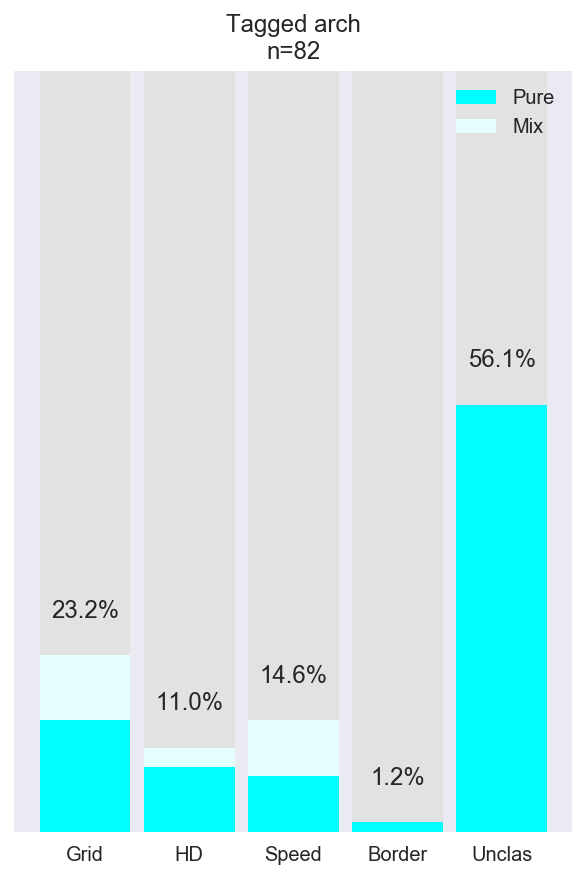

(0.14634146341463414, 0.08536585365853659, 0.07317073170731707, 0.012195121951219513, 0.5609756097560976)


In [19]:
# grid, hd, speed, border, unclassified
from palettable.cartocolors.sequential import DarkMint_4,Peach_6,RedOr_6,Teal_6
#colors = RedOr_6.get_mpl_colormap()

seq_col_brew = sns.color_palette(sns.light_palette("cyan",5))
sns.set_palette(seq_col_brew)
#sns.set(font_scale=1.4,style='white')
plt.figure(figsize=(5,7))


N = 5
pure = (pure_grid_len/all_len, pure_hd_len/all_len, pure_speed_len/all_len, pure_border_len/all_len, unclas_len/all_len)
mix = (mix_grid_len/all_len, mix_hd_len/all_len, mix_speed_len/all_len, mix_border_len/all_len,0)

rest = ((all_len-(pure_grid_len+mix_grid_len))/all_len,\
        (all_len-(pure_hd_len+mix_hd_len))/all_len,\
        (all_len-(pure_speed_len+mix_speed_len))/all_len,\
        (all_len-(pure_border_len+mix_border_len))/all_len,\
        (all_len-unclas_len)/all_len)

ind = np.arange(N)    # the x locations for the groups
width = 0.87       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pure, width, color=seq_col_brew[4])
p2 = plt.bar(ind, mix, width, color=seq_col_brew[0], bottom=pure)
p3 = plt.bar(ind, rest,width,color=plt.cm.Greys(0.2),bottom=[x+y for x,y in zip(pure,mix)])

labels = [frac_grid,frac_hd,frac_speed,frac_border,frac_unclas]
for i in ind:
    # write label:
    plt.text(i,labels[i]+.05,'{:.1f}%'.format(labels[i]*100),horizontalalignment='center')

#plt.ylabel('Fraction')
plt.xticks(ind, ('Grid', 'HD', 'Speed', 'Border','Unclas'))
plt.gca().get_yaxis().set_ticks([])

plt.legend((p1[0], p2[0]), ('Pure', 'Mix'))
plt.ylim(0,1)
plt.title(label)
sns.despine(left=True,bottom=True)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\tagged_stacked_bar.svg', format='svg', dpi=1000)
plt.show()
print(pure)

## Now make the same stacked bar but for all other cells

In [91]:
non_inhib_cells = arch_all[(arch_all.label != 'inhibited')].copy()# retrieves all cells that were not tagged
non_inhib_cells = non_inhib_cells[non_inhib_cells.artefact ==0]
label = 'untagged \nn={}'.format(len(non_inhib_cells))#and labels them

In [92]:
gridc = non_inhib_cells[non_inhib_cells.grid_score_bnt > grid_cutoff]
hdc = non_inhib_cells[(non_inhib_cells.tc_stats_mvl_bnt > mvl_cutoff)&(non_inhib_cells.angular_stability_bnt>0.6)]# plus stability
speedc = non_inhib_cells[non_inhib_cells.speedscore_bnt > speed_cutoff]
borderc = non_inhib_cells[non_inhib_cells.borderscore_bnt > border_cutoff]

unclas = non_inhib_cells[(non_inhib_cells.grid_score_bnt <= grid_cutoff) &\
               (non_inhib_cells.tc_stats_mvl_bnt <= mvl_cutoff) &\
               (non_inhib_cells.speedscore_bnt <= speed_cutoff) &\
               (non_inhib_cells.borderscore_bnt <= border_cutoff)]

In [93]:
pure_gridc = gridc[(~gridc.index.isin(hdc.index)) & (~gridc.index.isin(speedc.index)) & (~gridc.index.isin(borderc.index))]
pure_hdc = hdc[(~hdc.index.isin(gridc.index)) & (~hdc.index.isin(speedc.index)) & (~hdc.index.isin(borderc.index))]
pure_borderc = borderc[(~borderc.index.isin(gridc.index)) & (~borderc.index.isin(speedc.index)) & (~borderc.index.isin(hdc.index))]
pure_speedc = speedc[(~speedc.index.isin(gridc.index)) & (~speedc.index.isin(borderc.index)) & (~speedc.index.isin(hdc.index))]

In [94]:
all_len = len(non_inhib_cells)
# Grid
grid_len = len(gridc)
frac_grid = grid_len/all_len
pure_grid_len = len(pure_gridc)
mix_grid_len = grid_len-pure_grid_len

# HD
hd_len = len(hdc)
frac_hd = hd_len/all_len
pure_hd_len = len(pure_hdc)
mix_hd_len = hd_len-pure_hd_len

# Speed
speed_len = len(speedc)
frac_speed = speed_len/all_len
pure_speed_len = len(pure_speedc)
mix_speed_len = speed_len-pure_speed_len

# Border
border_len = len(borderc)
frac_border = border_len/all_len
pure_border_len = len(pure_borderc)
mix_border_len = border_len-pure_border_len

# Rest
unstable_HD = cells[(cells.tc_stats_mvl_bnt > mvl_cutoff)&(cells.angular_stability_bnt <= 0.6)]#must also add unstable head direction cells
unclas_len = len(unclas)+len(unstable_HD)
frac_unclas = unclas_len/all_len

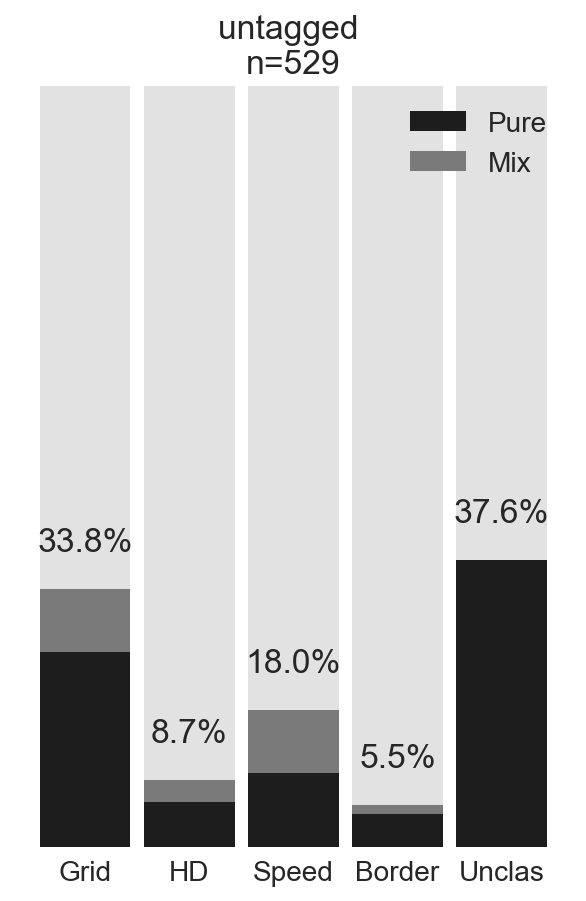

(0.2551984877126654, 0.05860113421550094, 0.09640831758034027, 0.043478260869565216, 0.3761814744801512)


In [95]:
# grid, hd, speed, border, unclassified
from palettable.cartocolors.sequential import DarkMint_4,Peach_6,RedOr_6,Teal_6
#colors = RedOr_6.get_mpl_colormap()
colors = cm.Greys

sns.set(font_scale=1.4,style='white')
plt.figure(figsize=(5,7))


N = 5
pure = (pure_grid_len/all_len, pure_hd_len/all_len, pure_speed_len/all_len, pure_border_len/all_len, unclas_len/all_len)
mix = (mix_grid_len/all_len, mix_hd_len/all_len, mix_speed_len/all_len, mix_border_len/all_len,0)

rest = ((all_len-(pure_grid_len+mix_grid_len))/all_len,\
        (all_len-(pure_hd_len+mix_hd_len))/all_len,\
        (all_len-(pure_speed_len+mix_speed_len))/all_len,\
        (all_len-(pure_border_len+mix_border_len))/all_len,\
        (all_len-unclas_len)/all_len)

ind = np.arange(N)    # the x locations for the groups
width = 0.87       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pure, width, color=colors(0.9))
p2 = plt.bar(ind, mix, width, color=colors(0.6), bottom=pure)
p3 = plt.bar(ind, rest,width,color=plt.cm.Greys(0.2),bottom=[x+y for x,y in zip(pure,mix)])

labels = [frac_grid,frac_hd,frac_speed,frac_border,frac_unclas]
for i in ind:
    # write label:
    plt.text(i,labels[i]+.05,'{:.1f}%'.format(labels[i]*100),horizontalalignment='center')

#plt.ylabel('Fraction')
plt.xticks(ind, ('Grid', 'HD', 'Speed', 'Border','Unclas'))
plt.gca().get_yaxis().set_ticks([])

plt.legend((p1[0], p2[0]), ('Pure', 'Mix'))
plt.ylim(0,1)
plt.title(label)
sns.despine(left=True,bottom=True)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\untagged_stacked_bar.svg', format='svg', dpi=1000)
plt.show()
print(pure)

## Compare scores between tagged and untagged populations
The following section will compare the functional properties between tagged and untagged cells.The code is essentially repeated for each variable. The only change is what is being ploted/compared. 


### Look at waveform stats

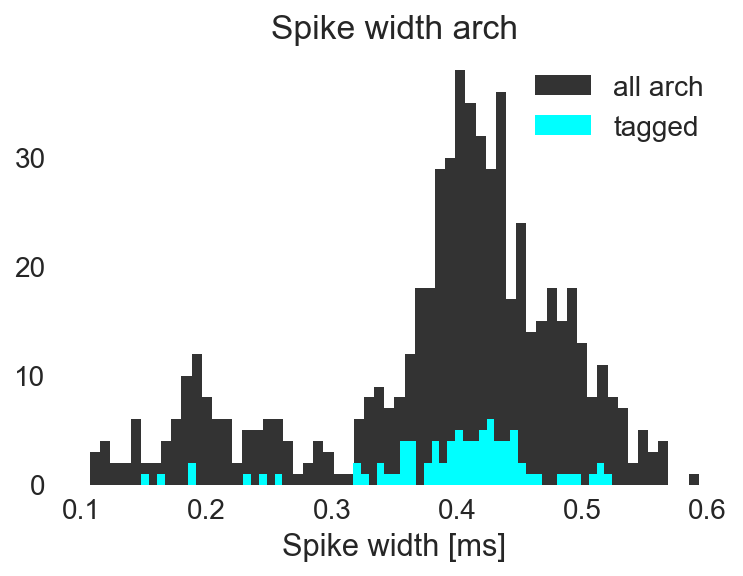

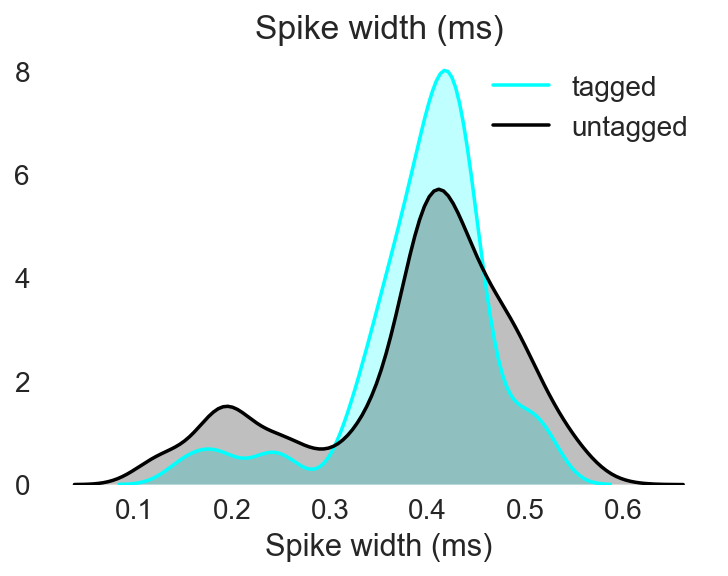

In [25]:
plt.hist(arch_all[arch_all.artefact==0].swidth,60,color='k',label='all arch',alpha=0.8);
plt.hist(cells[cells.artefact==0].swidth,60,color='cyan',label='tagged');
sns.despine(left=True,bottom=True)
plt.xlabel('Spike width [ms]')
plt.title('Spike width arch')
plt.legend()
plt.savefig(r'N:\davidcr\stellate paper images\python output\spike_width_hist', format='png', dpi=1000)
plt.show()

sns.kdeplot(cells[cells.artefact==0].swidth, shade=True, color="cyan",label='tagged')
sns.kdeplot(non_inhib_cells[non_inhib_cells.artefact==0].swidth, shade=True, color="black",label='untagged')
sns.despine(left=True,bottom=True)
plt.xlabel('Spike width (ms)')
plt.title('Spike width (ms)')
plt.legend()
plt.savefig(r'N:\davidcr\stellate paper images\python output\spike_width_kde', format='png', dpi=1000)
plt.show()

In [77]:
import scipy as scipy
from scipy.stats import mannwhitneyu
scipy.stats.mannwhitneyu(inhib_cells[inhib_cells.artefact==0].swidth, non_inhib_cells[non_inhib_cells.artefact==0].swidth)

MannwhitneyuResult(statistic=20900.5, pvalue=0.29812759060867544)

### Look at grid score 

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


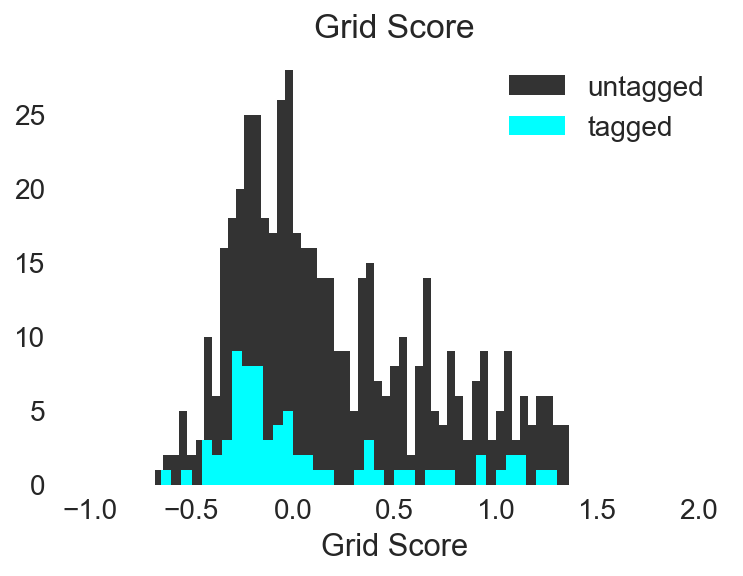

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


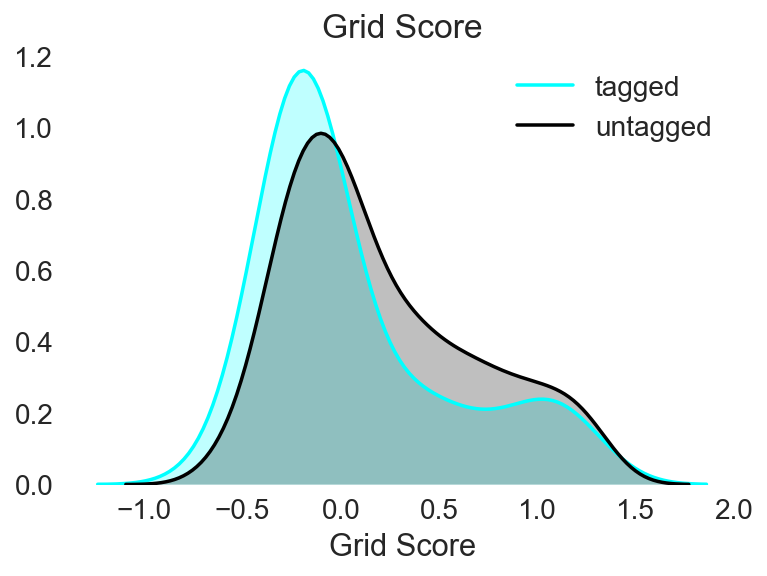

In [27]:
plt.hist(non_inhib_cells[non_inhib_cells.artefact==0].grid_score_bnt,60,color='k',label='untagged',alpha=0.8,range=[-1, 1.4]);
plt.hist(cells[cells.artefact==0].grid_score_bnt,60,color='cyan',label='tagged',range=[-1, 2]);

sns.despine(left=True,bottom=True)
plt.xlabel('Grid Score')
plt.title('Grid Score')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\grid_score_hist.svg', format='svg', dpi=1000)
plt.show()

sns.kdeplot(cells[cells.artefact==0].grid_score_bnt, shade=True, color="cyan",label='tagged')
sns.kdeplot(non_inhib_cells[non_inhib_cells.artefact==0].grid_score_bnt, shade=True, color="black",label='untagged')
sns.despine(left=True,bottom=True)
 
plt.xlabel('Grid Score')
plt.title('Grid Score')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\grid_score_kde.svg', format='svg', dpi=1000)
plt.show()

In [96]:
import scipy as scipy
from scipy.stats import mannwhitneyu
scipy.stats.mannwhitneyu(inhib_cells.grid_score_bnt, non_inhib_cells.grid_score_bnt)

MannwhitneyuResult(statistic=20525.0, pvalue=0.21703332161663952)

In [89]:
len(non_inhib_cells)

541

### Look at speed score

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


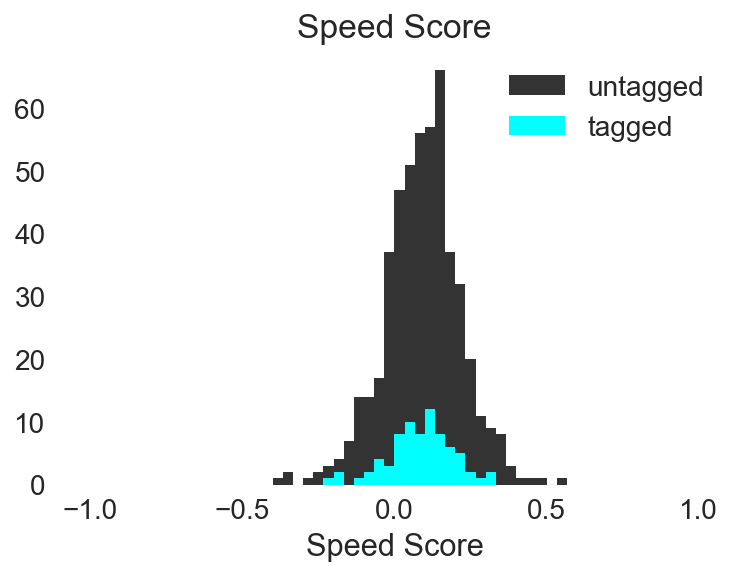

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


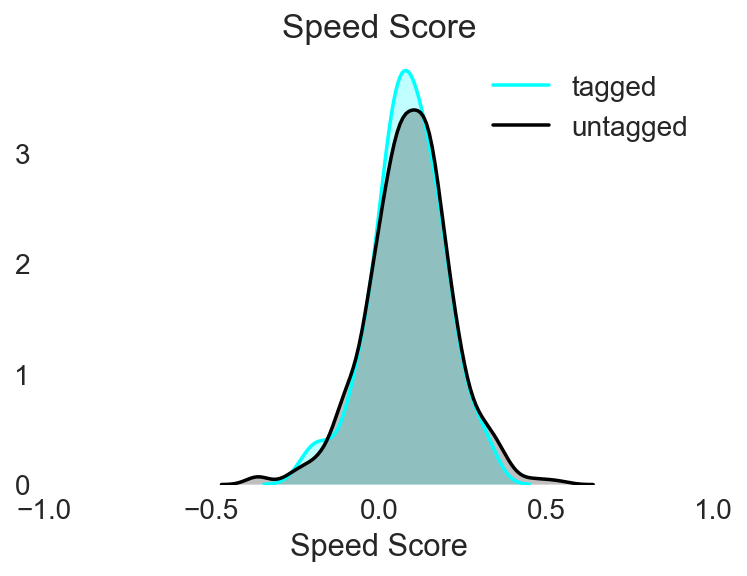

In [29]:
plt.hist(non_inhib_cells[non_inhib_cells.artefact==0].speedscore_bnt,60,color='k',label='untagged',alpha=0.8,range=[-1, 1]);
plt.hist(cells[cells.artefact==0].speedscore_bnt,60,color='cyan',label='tagged',range=[-1, 1]);

sns.despine(left=True,bottom=True)
plt.xlabel('Speed Score')
plt.title('Speed Score')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\speed_score_hist.svg', format='svg', dpi=1000)
plt.show()

sns.kdeplot(cells[cells.artefact==0].speedscore_bnt, shade=True, color="cyan",label='tagged')
sns.kdeplot(non_inhib_cells[non_inhib_cells.artefact==0].speedscore_bnt, shade=True, color="black",label='untagged')
sns.despine(left=True,bottom=True)
plt.xlabel('Speed Score')
plt.xlim( (-1, 1) ) 
plt.title('Speed Score')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\speed_score_kde.svg', format='svg', dpi=1000)
plt.show()

In [97]:
import scipy as scipy
from scipy.stats import mannwhitneyu
scipy.stats.mannwhitneyu(cells.speedscore_bnt, non_inhib_cells.speedscore_bnt)

MannwhitneyuResult(statistic=21596.0, pvalue=0.47520568737404956)

### look at directional tuning

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


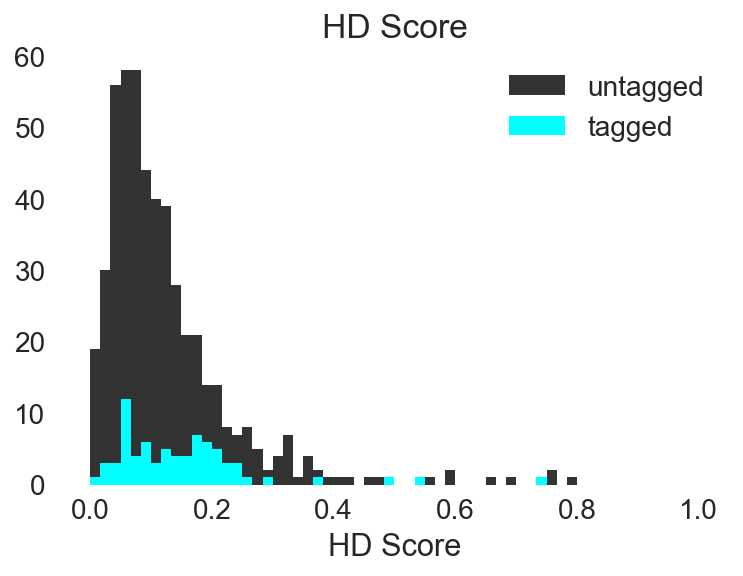

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


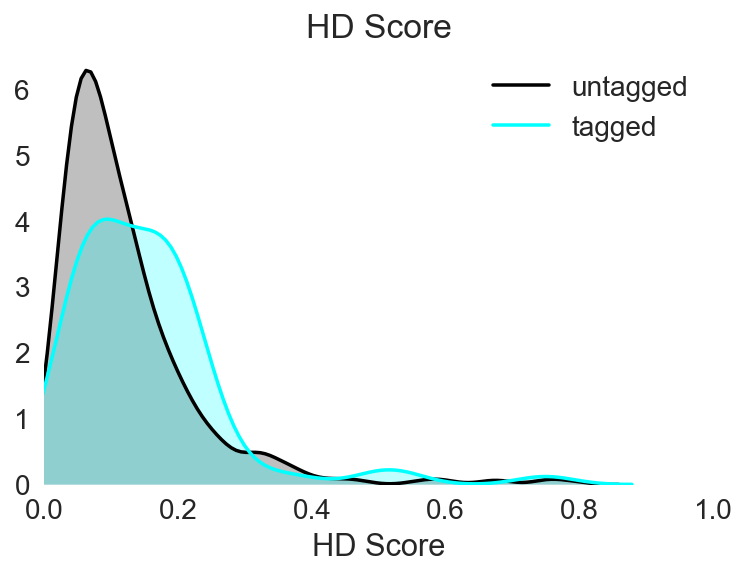

In [31]:
plt.hist(non_inhib_cells[non_inhib_cells.artefact==0].tc_stats_mvl_bnt,60,color='k',label='untagged',alpha=0.8,range=[0, 1]);
plt.hist(cells[cells.artefact==0].tc_stats_mvl_bnt,60,color='cyan',label='tagged',range=[0, 1]);

sns.despine(left=True,bottom=True)
plt.xlabel('HD Score')
plt.title('HD Score')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\head_direction_hist.svg', format='svg', dpi=1000)
plt.show()


sns.kdeplot(non_inhib_cells[non_inhib_cells.artefact==0].tc_stats_mvl_bnt, shade=True, color="black",label='untagged')
sns.kdeplot(cells[cells.artefact==0].tc_stats_mvl_bnt, shade=True, color="cyan",label='tagged')
sns.despine(left=True,bottom=True)
plt.xlim( (0, 1) ) 
plt.xlabel('HD Score')
plt.title('HD Score')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\head_direction_kde.svg', format='svg', dpi=1000)
plt.show()

In [98]:
import scipy as scipy
from scipy.stats import mannwhitneyu
scipy.stats.mannwhitneyu(cells.tc_stats_mvl_bnt, non_inhib_cells.tc_stats_mvl_bnt)

MannwhitneyuResult(statistic=16113.0, pvalue=8.8927916094135105e-05)

### Look at spatial information 

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


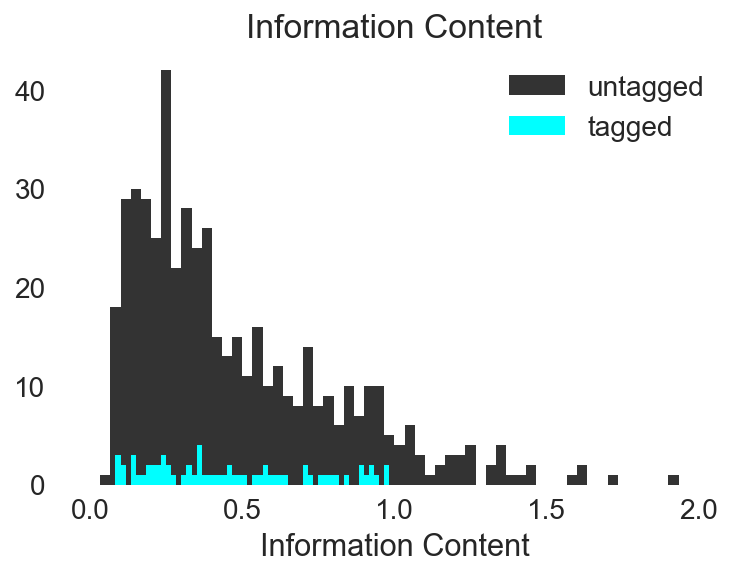

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


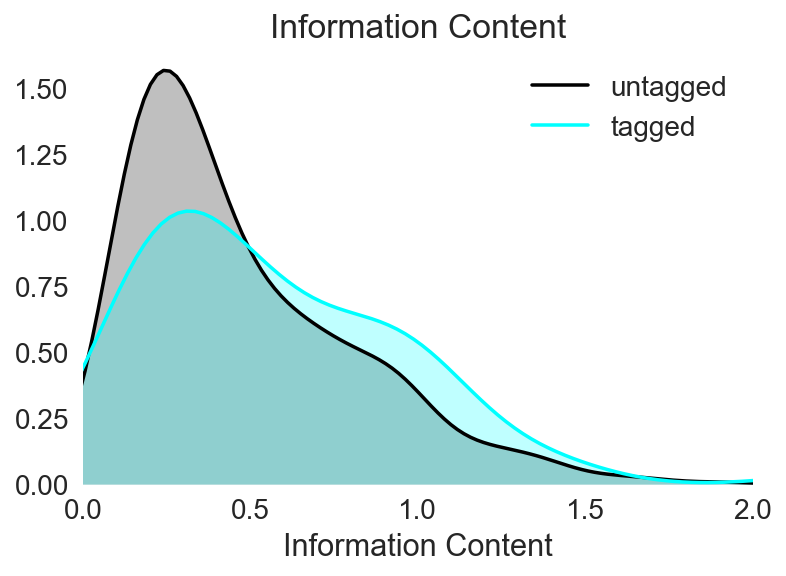

In [33]:
plt.hist(non_inhib_cells[non_inhib_cells.artefact==0].informationcontent_bnt,60,color='k',label='untagged',alpha=0.8,range=[0, 2.0]);
plt.hist(cells[cells.artefact==0].informationcontent_bnt,60,color='cyan',label='tagged',range=[0, 1]);

sns.despine(left=True,bottom=True)
plt.xlabel('Information Content')
plt.title('Information Content')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\spatial_info_hist.svg', format='svg', dpi=1000)
plt.show()


sns.kdeplot(non_inhib_cells[non_inhib_cells.artefact==0].informationcontent_bnt, shade=True, color="black",label='untagged')
sns.kdeplot(cells[cells.artefact==0].informationcontent_bnt, shade=True, color="cyan",label='tagged')
sns.despine(left=True,bottom=True)
plt.xlim( (0, 2) ) 
plt.xlabel('Information Content')
plt.title('Information Content')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\spatial_info_kde.svg', format='svg', dpi=1000)
plt.show()

In [99]:
import scipy as scipy
from scipy.stats import mannwhitneyu
scipy.stats.mannwhitneyu(cells.informationcontent_bnt, non_inhib_cells.informationcontent_bnt)

MannwhitneyuResult(statistic=18140.0, pvalue=0.0085221632205771478)

### look at border score

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


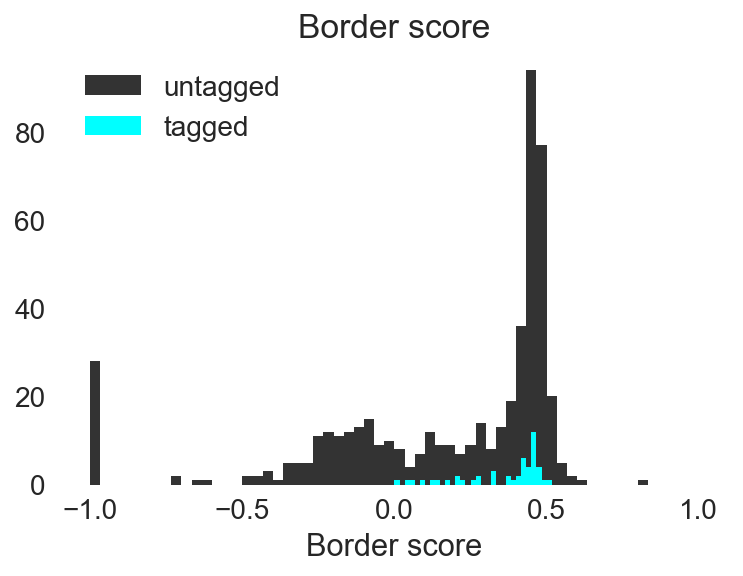

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


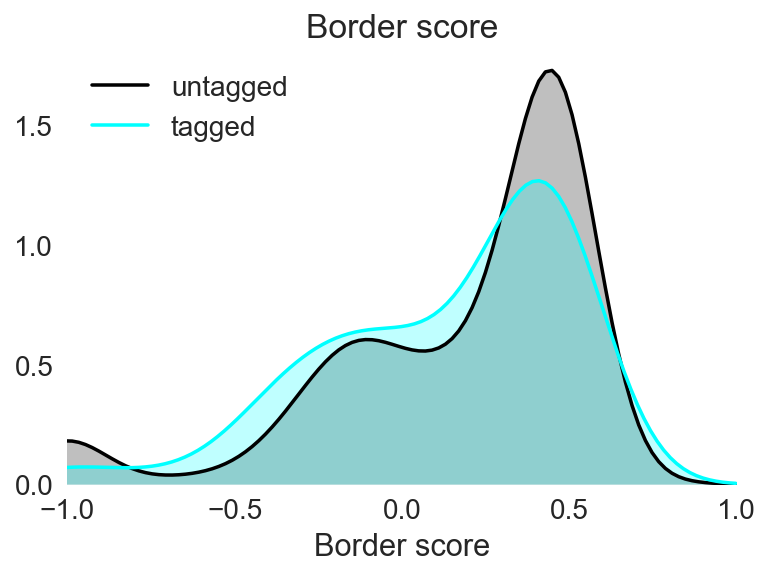

In [35]:
plt.hist(non_inhib_cells[non_inhib_cells.artefact==0].borderscore_bnt,60,color='k',label='untagged',alpha=0.8,range=[-1, 1.0]);
plt.hist(cells[cells.artefact==0].borderscore_bnt,60,color='cyan',label='tagged',range=[0, 1]);

sns.despine(left=True,bottom=True)
plt.xlabel('Border score')
plt.title('Border score')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\border_score_hist.svg', format='svg', dpi=1000)
plt.show()


sns.kdeplot(non_inhib_cells[non_inhib_cells.artefact==0].borderscore_bnt, shade=True, color="black",label='untagged')
sns.kdeplot(cells[cells.artefact==0].borderscore_bnt, shade=True, color="cyan",label='tagged')
sns.despine(left=True,bottom=True)
plt.xlim( (-1.0, 1) ) 
plt.xlabel('Border score')
plt.title('Border score')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\border_score_kde.svg', format='svg', dpi=1000)
plt.show()

In [36]:
import scipy as scipy
from scipy.stats import mannwhitneyu
scipy.stats.mannwhitneyu(cells[cells.artefact==0].borderscore_bnt, non_inhib_cells[non_inhib_cells.artefact==0].borderscore_bnt)

MannwhitneyuResult(statistic=19909.0, pvalue=0.11576851304403546)

### now look at burstiness

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


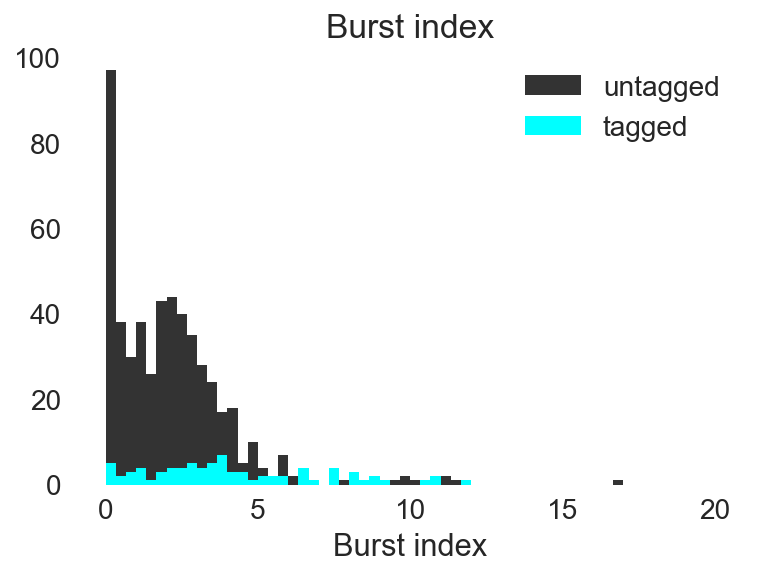

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


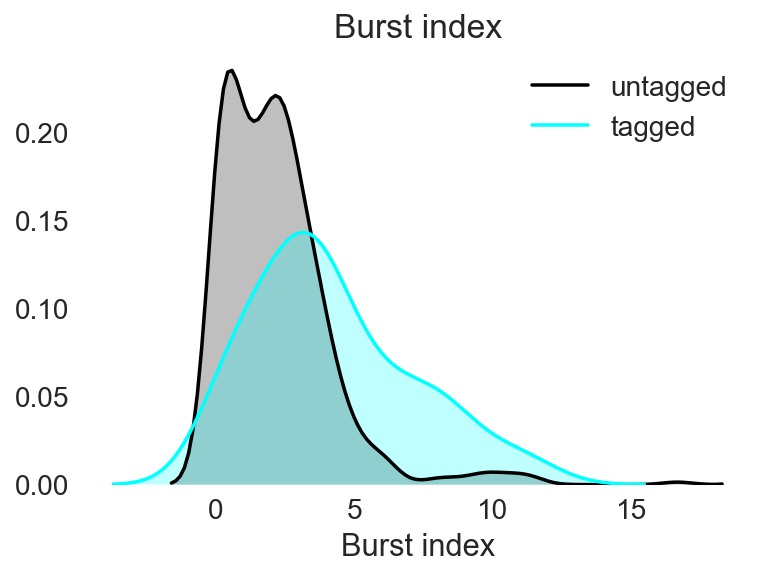

In [37]:
plt.hist(non_inhib_cells[non_inhib_cells.artefact==0].burst_idx2,60,color='k',label='untagged',alpha=0.8,range=[0, 20]);
plt.hist(cells[cells.artefact==0].burst_idx2,60,color='cyan',label='tagged',range=[0, 20]);

sns.despine(left=True,bottom=True)
plt.xlabel('Burst index')
plt.title('Burst index')
plt.legend()
plt.show()


sns.kdeplot(non_inhib_cells[non_inhib_cells.artefact==0].burst_idx2, shade=True, color="black",label='untagged')
sns.kdeplot(cells[cells.artefact==0].burst_idx2, shade=True, color="cyan",label='tagged')
sns.despine(left=True,bottom=True)
plt.xlabel('Burst index')
plt.title('Burst index')
plt.legend()
plt.show()

In [38]:
import scipy as scipy
from scipy.stats import mannwhitneyu
scipy.stats.mannwhitneyu(cells[cells.artefact==0].burst_idx2, non_inhib_cells[non_inhib_cells.artefact==0].burst_idx2)

MannwhitneyuResult(statistic=11817.5, pvalue=1.6046183823865094e-11)

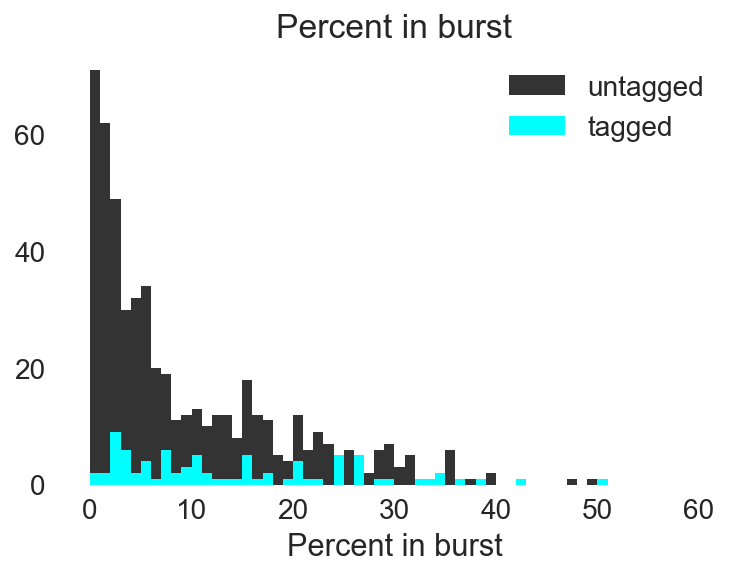

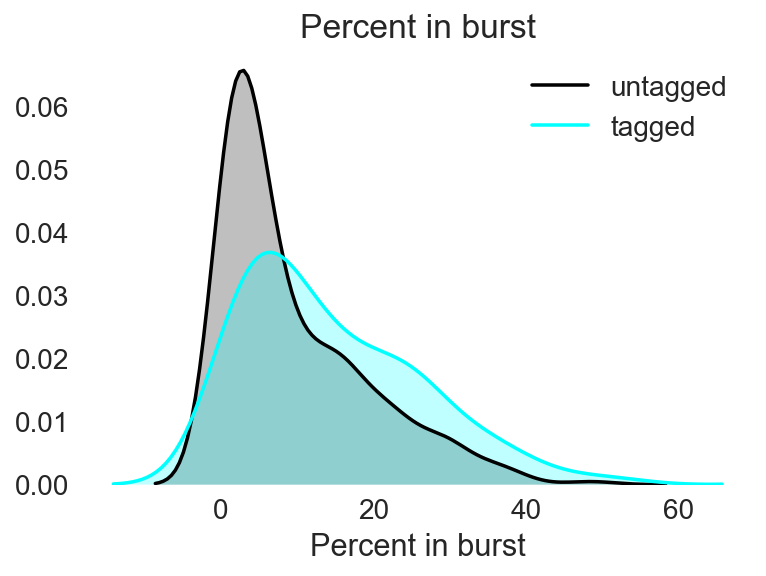

In [39]:
plt.hist(non_inhib_cells[non_inhib_cells.artefact==0].isi_stats_percent_bursts,60,color='k',label='untagged',alpha=0.8,range=[0, 60]);
plt.hist(cells[cells.artefact==0].isi_stats_percent_bursts,60,color='cyan',label='tagged',range=[0, 60]);

sns.despine(left=True,bottom=True)
plt.xlabel('Percent in burst')
plt.title('Percent in burst')
plt.legend()
plt.show()


sns.kdeplot(non_inhib_cells[non_inhib_cells.artefact==0].isi_stats_percent_bursts, shade=True, color="black",label='untagged')
sns.kdeplot(cells[cells.artefact==0].isi_stats_percent_bursts, shade=True, color="cyan",label='tagged')
sns.despine(left=True,bottom=True)
plt.xlabel('Percent in burst')
plt.title('Percent in burst')
plt.legend()
plt.show()

## section for plotting as a violin plot instead

## Make some violin plots for comparison 

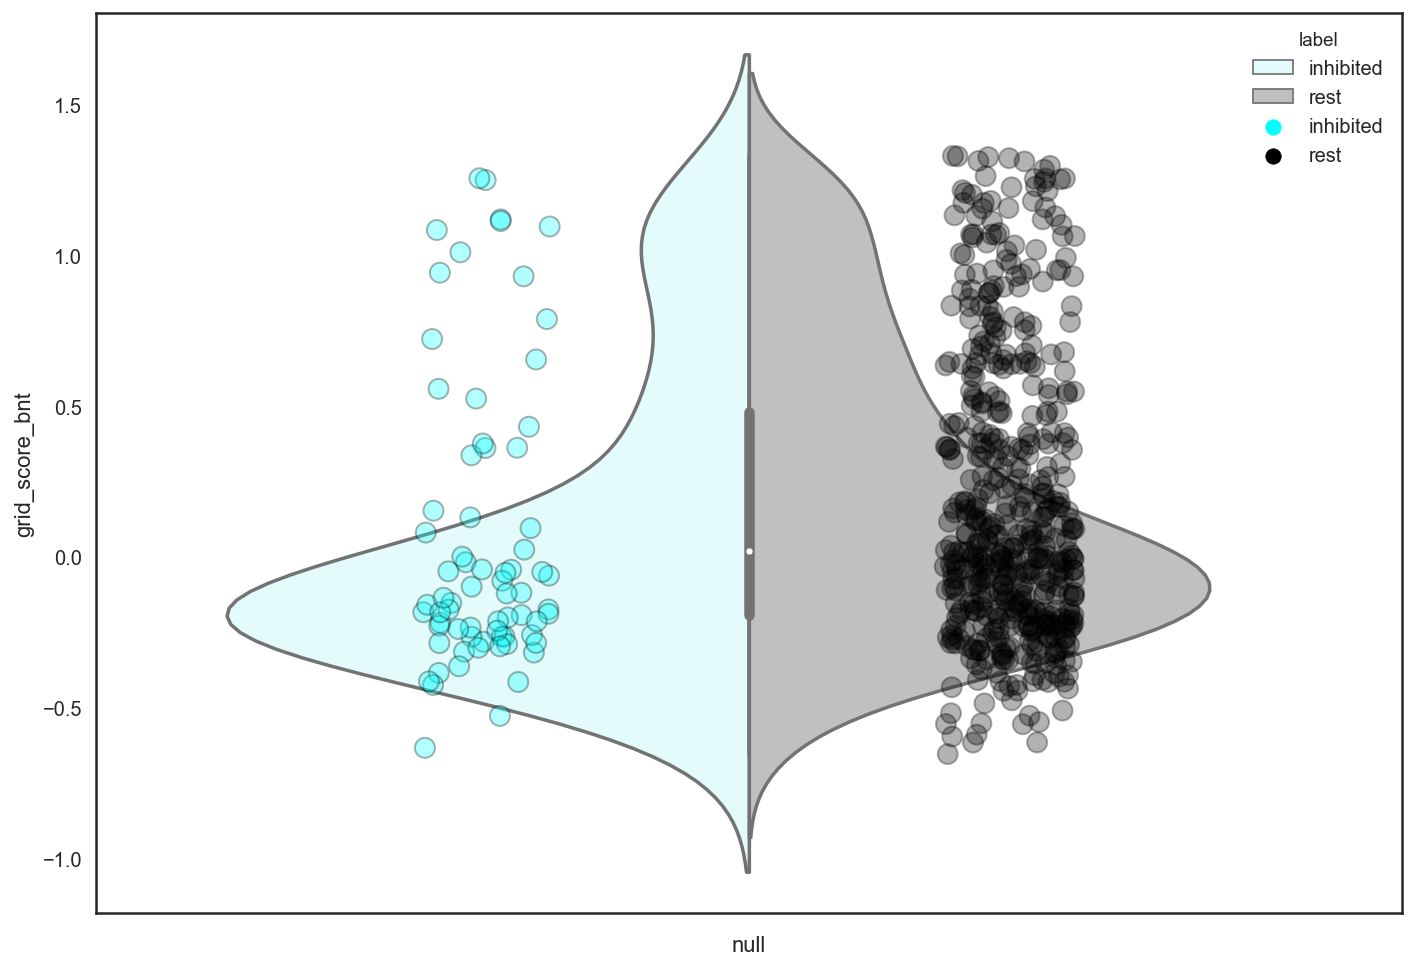

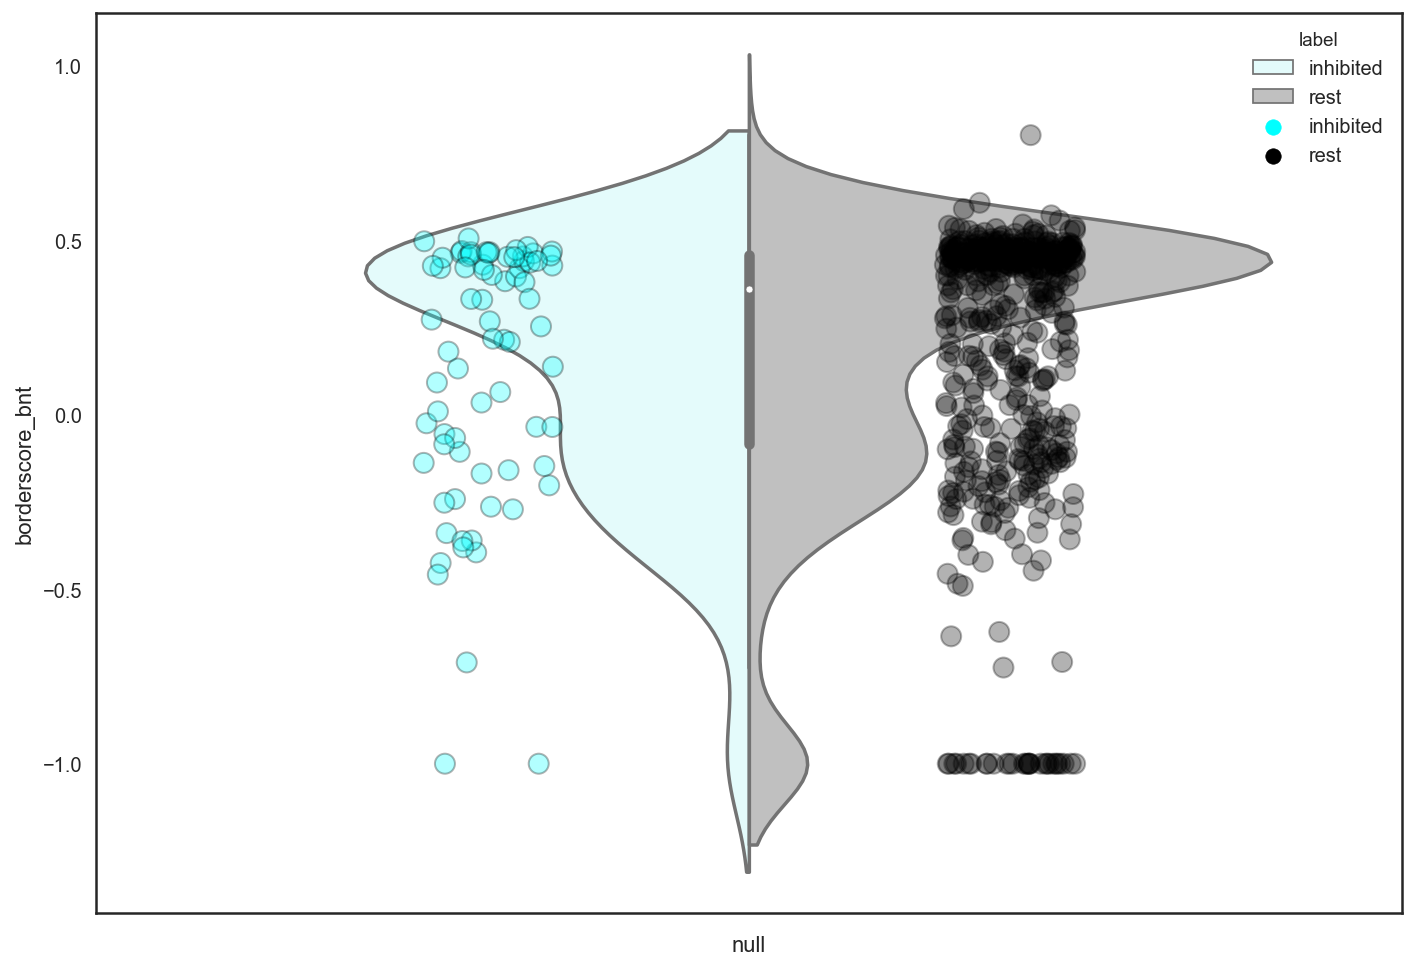

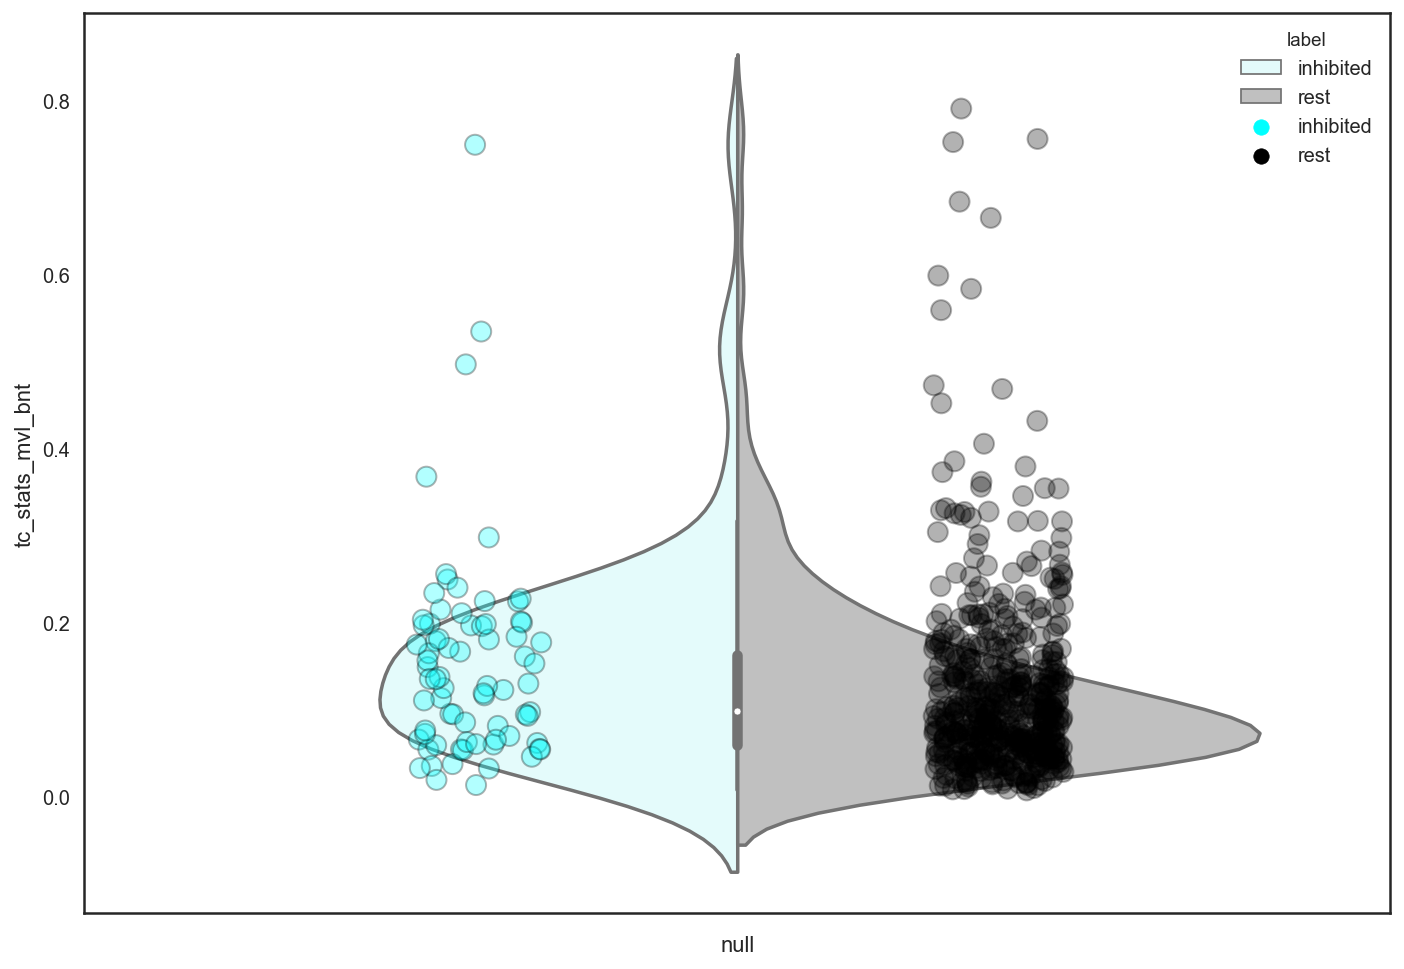

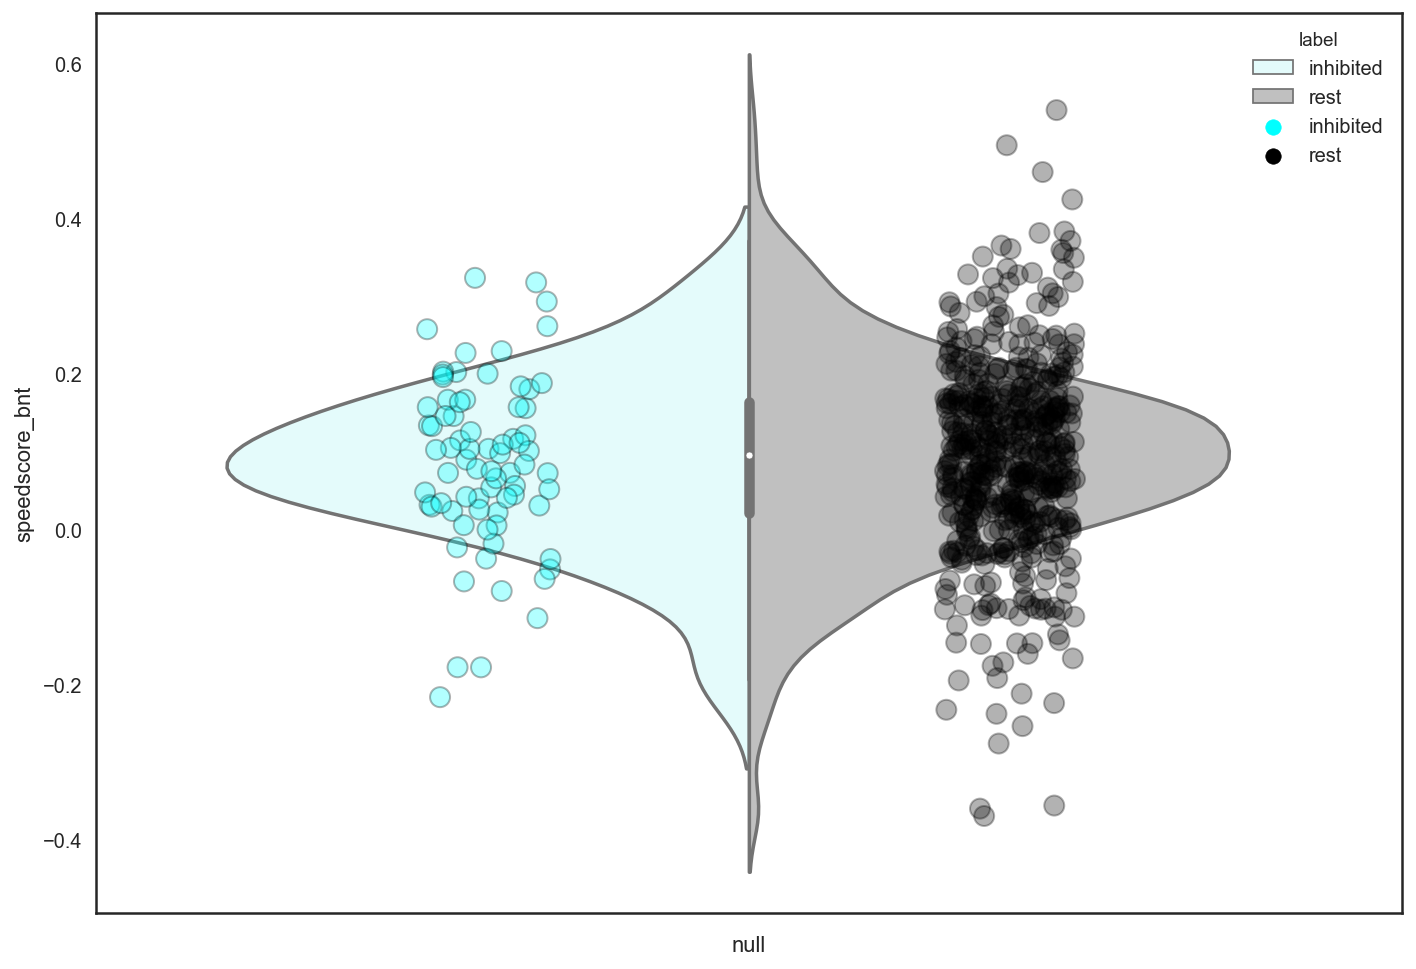

In [74]:
figure = plt.figure(facecolor='w')

sns.set(font_scale=1.)
sns.set_style('white')
 
    

figure.set_size_inches(11.7, 8.27)

sns.set_style("white")

arch_all["null"] = ""

taggedCM = ["#e0ffff", "#C0C0C0"]
sns.set_palette(taggedCM)
#sns.palplot(sns.color_palette())

ax = sns.violinplot(x = arch_all["null"],y=arch_all.grid_score_bnt.astype(float) , hue = arch_all.label,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)
ax = sns.stripplot(x = arch_all["null"],y=arch_all.grid_score_bnt.astype(float) , hue = arch_all.label,jitter = True, dodge = True, size=10,linewidth=1,alpha = 0.3)
plt.savefig(r'N:\davidcr\stellate paper images\python output\grid_score_violin.svg', format='svg', dpi=1000)


figure = plt.figure(facecolor='w')
sns.set(font_scale=1.)
figure.set_size_inches(11.7, 8.27)
sns.set_style("white")

taggedCM = ["#e0ffff", "#C0C0C0"]
sns.set_palette(taggedCM)
ax2 = sns.violinplot(x = arch_all["null"],y=arch_all.borderscore_bnt.astype(float) , hue = arch_all.label,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)
ax2 = sns.stripplot(x = arch_all["null"],y=arch_all.borderscore_bnt.astype(float) , hue = arch_all.label,jitter = True, dodge = True, size=10,linewidth=1,alpha = 0.3)
plt.savefig(r'N:\davidcr\stellate paper images\python output\border_score_violin.svg', format='svg', dpi=1000)


figure = plt.figure(facecolor='w')
sns.set(font_scale=1.)
figure.set_size_inches(11.7, 8.27)
sns.set_style("white")

taggedCM = ["#e0ffff", "#C0C0C0"]
sns.set_palette(taggedCM)
ax2 = sns.violinplot(x = arch_all["null"],y=arch_all.tc_stats_mvl_bnt.astype(float) , hue = arch_all.label,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)
ax2 = sns.stripplot(x = arch_all["null"],y=arch_all.tc_stats_mvl_bnt.astype(float) , hue = arch_all.label,jitter = True, dodge = True, size=10,linewidth=1,alpha = 0.3 )
plt.savefig(r'N:\davidcr\stellate paper images\python output\HD_score_violin.svg', format='svg', dpi=1000)


figure = plt.figure(facecolor='w')
sns.set(font_scale=1.)
figure.set_size_inches(11.7, 8.27)
sns.set_style("white")

taggedCM = ["#e0ffff", "#C0C0C0"]
sns.set_palette(taggedCM)
ax2 = sns.violinplot(x = arch_all["null"],y=arch_all.speedscore_bnt.astype(float) , hue = arch_all.label,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)
ax2 = sns.stripplot(x = arch_all["null"],y=arch_all.speedscore_bnt.astype(float) , hue = arch_all.label,jitter = True, dodge = True, size=10, linewidth=1, alpha = 0.3)
plt.savefig(r'N:\davidcr\stellate paper images\python output\speed_score_violin.svg', format='svg', dpi=1000)



## Now check classifier perfomance on tagged cells

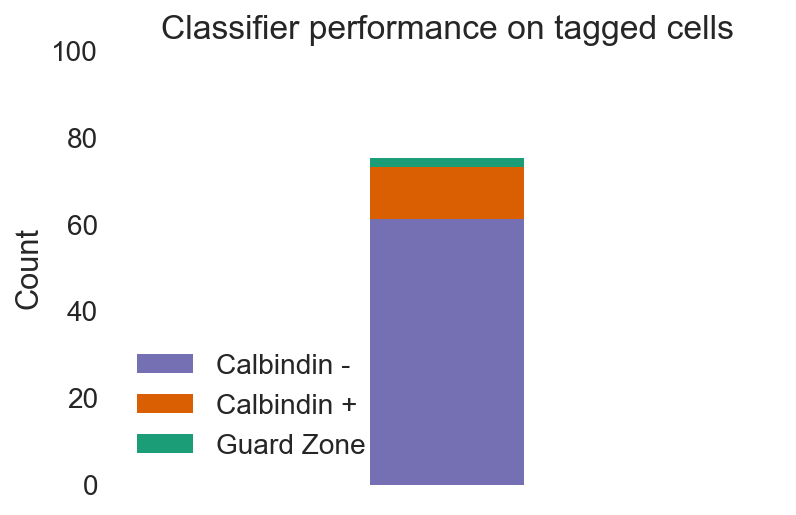

12
2
61


In [53]:
# retrieve tagged cells again
cells = arch_all[(arch_all.label == 'inhibited')].copy()
# get 3 different sets: 
figure.set_size_inches(11.7, 8.27)
calbindin = cells[(cells.calbindin_bnt == 1)&(np.fabs(cells.calbindin_dist_bnt_single)>=0.1)]
stellate = cells[(cells.calbindin_bnt == 0)&(np.fabs(cells.calbindin_dist_bnt_single)>=0.1)]
rest =cells[np.fabs(cells.calbindin_dist_bnt_single)<0.1]
cb = len(calbindin)
st = len(stellate)
r = len(rest)
width = 0.23
ind = 1
p1 = plt.bar(ind, st, width, color='#7570b3')
p2 = plt.bar(ind, cb, width, color='#d95f02', bottom=st)
p3 = plt.bar(ind, r,width,color='#1b9e77',bottom=[cb+st])


plt.gca().get_xaxis().set_ticks([])

plt.legend((p1[0], p2[0],p3[0]), ('Calbindin -', 'Calbindin +', 'Guard Zone'))
plt.ylim(0,100)
plt.xlim(0.5,1.5)
plt.title('Classifier performance on tagged cells')
plt.ylabel('Count')
sns.despine(left=True,bottom=True)
plt.savefig(r'N:\davidcr\stellate paper images\python output\tagged_classifier.svg', format='svg', dpi=1000)
plt.show()
print(len(calbindin))
print(len(rest))
print(len(stellate))

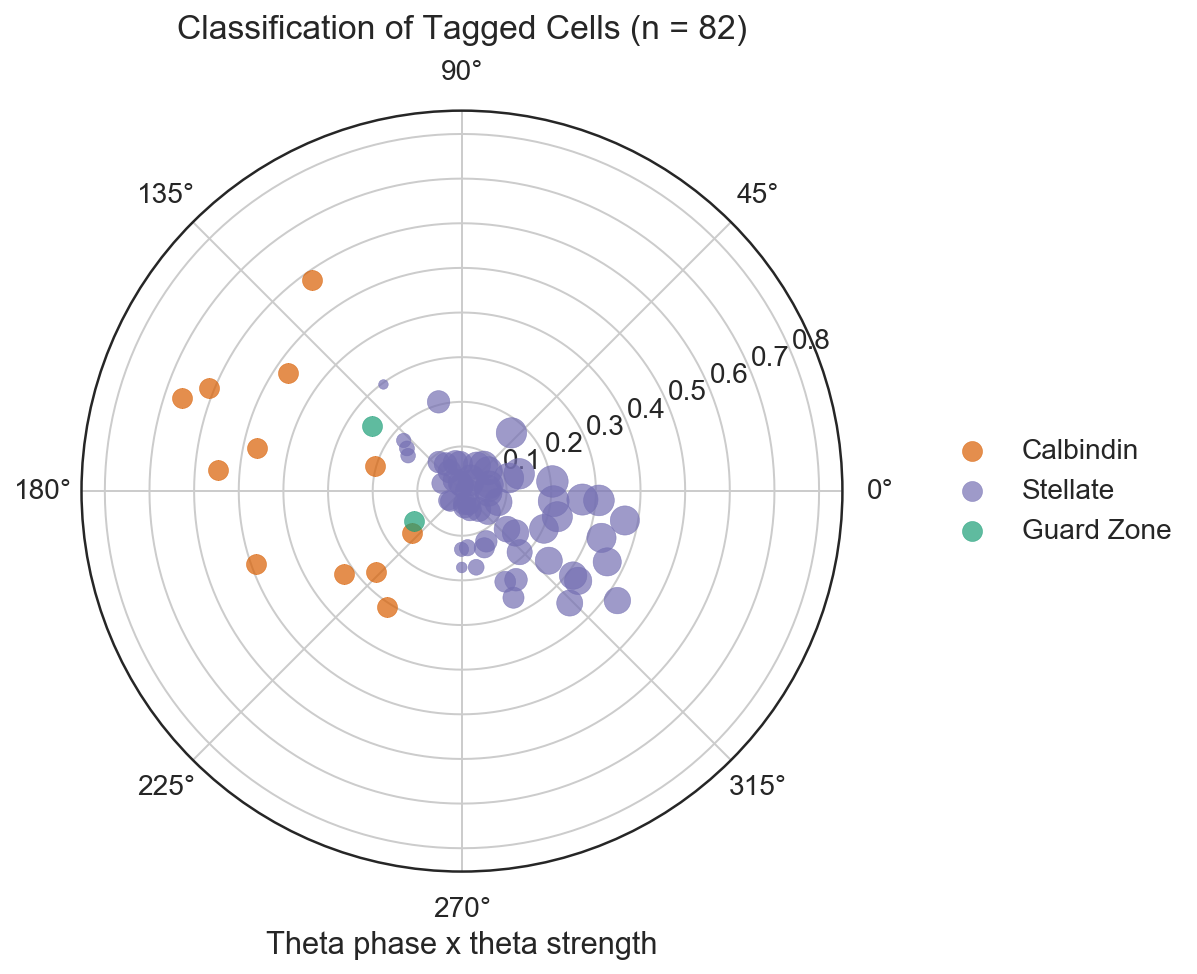

In [71]:
sns.set(font_scale=1.4,style='white')
figure = plt.figure(figsize=(15,7))
ax = figure.add_subplot(1,2,1,projection='polar')
ax.scatter(calbindin.theta_mean_phase_bnt_single.values.astype(float),calbindin.theta_strength_bnt_single.values.astype(float),c='#d95f02',alpha=.7,label='Calbindin',s = 100)
ax.scatter(stellate.theta_mean_phase_bnt_single.values.astype(float),stellate.theta_strength_bnt_single.values.astype(float),c='#7570b3',alpha=.7,label='Stellate',s=(stellate.calbindin_dist_bnt_single*200).astype(int))
ax.scatter(rest.theta_mean_phase_bnt_single.values.astype(float),rest.theta_strength_bnt_single.values.astype(float),c='#1b9e77',alpha=.7,label='Guard Zone', s = 100)
ax.set_xlabel('Theta phase x theta strength')
plt.title('Classification of Tagged Cells (n = 82)',  y=1.08)
lgnd = plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\circular phase vs strength all tagged.svg', format='svg', dpi=1000, bbox_inches='tight')

plt.show()

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\matplotlib\collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


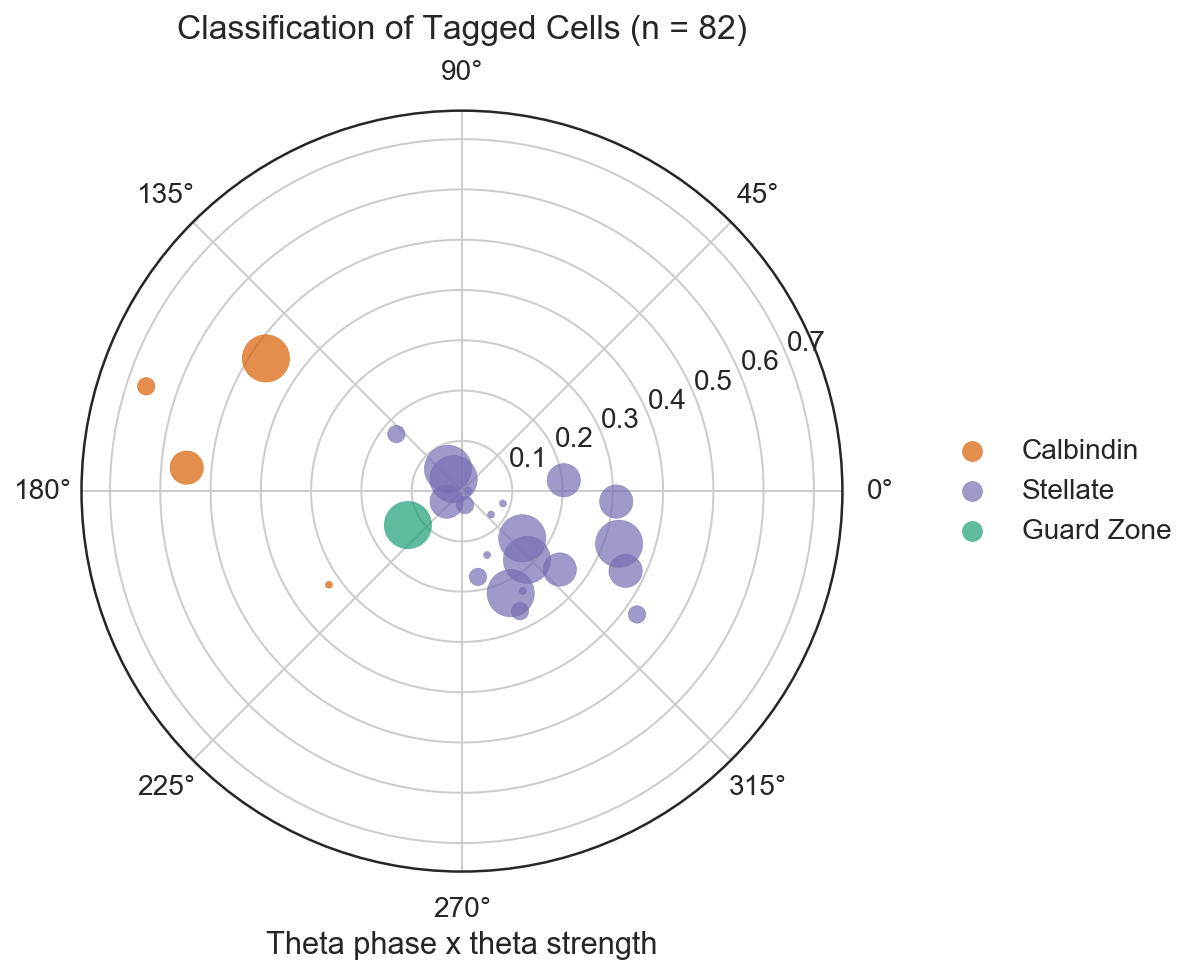

In [50]:
sns.set(font_scale=1.4,style='white')
figure = plt.figure(figsize=(15,7))
ax = figure.add_subplot(1,2,1,projection='polar')
ax.scatter(calbindin.theta_mean_phase_bnt_single.values.astype(float),calbindin.theta_strength_bnt_single.values.astype(float),c='#d95f02',alpha=.7,label='Calbindin',s=(calbindin.grid_score_bnt*500).astype(int))
ax.scatter(stellate.theta_mean_phase_bnt_single.values.astype(float),stellate.theta_strength_bnt_single.values.astype(float),c='#7570b3',alpha=.7,label='Stellate',s=(calbindin.grid_score_bnt*500).astype(int))
ax.scatter(rest.theta_mean_phase_bnt_single.values.astype(float),rest.theta_strength_bnt_single.values.astype(float),c='#1b9e77',alpha=.7,label='Guard Zone', s=(calbindin.grid_score_bnt*500).astype(int))
ax.set_xlabel('Theta phase x theta strength')
plt.title('Classification of Tagged Cells (n = 82)',  y=1.08)
lgnd = plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\circular phase vs strength by grid score.svg', format='svg', dpi=1000, bbox_inches='tight')

plt.show()

In [73]:
np.mean(calbindin.calbindin_dist_bnt)

-0.86700856085175004

###### psql = psql_neuroballs(arch_all) # initialize retrieval
dict_ = {'BNT_tb_iso':('lratio','isodist')}
filter_ = "NOT LIKE '%obj%' AND session_name NOT LIKE '%stab%' AND session_name NOT LIKE '%rest%' AND session_name NOT LIKE '%room%' AND session_name NOT LIKE '%bord%'"

arch_all = psql.retrieve_data(user_sql_tables=dict_,user_sql_filter=filter_)
ax = sns.violinplot(x = arch_all["null"],y=arch_all.lratio.astype(float) , hue = arch_all.label,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)
ax = sns.stripplot(x = arch_all["null"],y=arch_all.lratio.astype(float) , hue = arch_all.label,jitter = True, dodge = True, size=10,linewidth=1,alpha = 0.3)
plt.show()

ax2 = sns.violinplot(x = arch_all["null"],y=arch_all.isodist.astype(float) , hue = arch_all.label,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)
ax2 = sns.stripplot(x = arch_all["null"],y=arch_all.isodist.astype(float) , hue = arch_all.label,jitter = True, dodge = True, size=10,linewidth=1,alpha = 0.3)
plt.ylim(0,50)
plt.show()

###### scipy.stats.mannwhitneyu(cells[cells.artefact==0].isodist, non_inhib_cells[non_inhib_cells.artefact==0].isodist)

###### np.mean(non_inhib_cells.isodist)

###### scipy.stats.mannwhitneyu(cells[cells.artefact==0].theta_strength_bnt_single, non_inhib_cells[non_inhib_cells.artefact==0].burst_idx2)

###### plt.show()

###### plt.scatter(non_inhib_cells[non_inhib_cells.artefact==0].grid_score_bnt,non_inhib_cells[non_inhib_cells.artefact==0].isodist)
plt.ylim(0,50)
plt.show()
